In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from copy import deepcopy

from shallow.torch import MAF, NSF

device = torch.device('cpu')
np.random.seed(42)

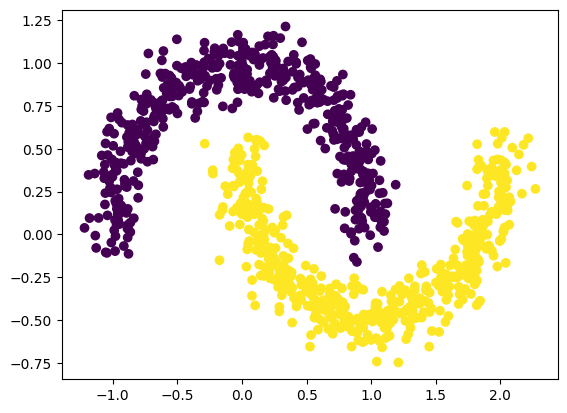

In [2]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [3]:
def train(
    model,
    epochs=1000,
    batch_size=128,
    learning_rate=1e-3,
    weight_decay=0.,
    ):
    
    model = model.to(device)
    loss_fn = lambda inputs, conditions: -model.log_prob(inputs, conditions).mean()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay,
        )
    best_epoch = 0
    best_loss = np.inf
    best_model = deepcopy(model)
    
    for epoch in range(epochs):
        
        model.train()
        
        x, y = datasets.make_moons(batch_size, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y[:, None], dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        loss = loss_fn(x, y)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        if loss < best_loss:
            best_epoch = epoch
            best_loss = loss
            best_model = deepcopy(model)
            
        print(epoch, loss)
            
    return best_epoch, best_loss, best_model


def test_condition(
    model,
    condition=0.,
    n=200,
    lim=None,
    plot=True,
    ):
    
    model.eval()
    
    x = np.linspace(-lim, lim, n)
    y = np.linspace(-lim, lim, n)
    xg, yg = np.meshgrid(x, y)
    xg = np.reshape(xg, (-1, 1))
    yg = np.reshape(yg, (-1, 1))
    
    xy = np.concatenate([xg, yg], axis=1)
    
    with torch.no_grad():
        zg = model.log_prob(
            torch.tensor(xy, dtype=torch.float32),
            torch.tensor([[condition]]*n**2, dtype=torch.float32),
            ).exp().numpy().reshape(n, n)

    if plot:
        plt.imshow(
            zg, origin='lower', aspect='equal', extent=(-lim, lim, -lim, lim),
            )
        
    return zg
        
        
def test(model, n=200, lim=3):
    
    zg = np.zeros((n, n))
    for condition in [0, 1]:
        zg += test_condition(model, condition, n, lim, False)
        
    plt.imshow(
        zg, origin='lower', aspect='equal', extent=(-lim, lim, -lim, lim),
        )

## MAF

In [14]:
maf = MAF(
    inputs=2,
    conditions=1,
    bounds=None,
    hidden=10,
    blocks=2,
    activation=torch.nn.functional.elu,
    dropout=0.,
    norm_within=False,
    transforms=2,
    permutation='reverse',
    linear=None,
    norm_inputs=None,
    norm_conditions=None,
    norm_between=False,
    embedding=torch.nn.Identity(),
    distribution=None,
    residual=True,
    )

epoch, loss, maf = train(maf, learning_rate=1e-2)

0 3.6561951637268066
1 3.344151735305786
2 3.0587611198425293
3 2.7909765243530273
4 2.579955816268921
5 2.384298801422119
6 2.204930067062378
7 2.075544595718384
8 1.9068491458892822
9 1.755789875984192
10 1.6623814105987549
11 1.6302084922790527
12 1.5554730892181396
13 1.4953867197036743
14 1.4634218215942383
15 1.490982174873352
16 1.4478503465652466
17 1.5121240615844727
18 1.4308550357818604
19 1.4328714609146118
20 1.4312800168991089
21 1.5020403861999512
22 1.4073386192321777
23 1.4363123178482056
24 1.4269684553146362
25 1.4702352285385132
26 1.3380986452102661
27 1.3548846244812012
28 1.4466761350631714
29 1.3994567394256592
30 1.3636975288391113
31 1.401168942451477
32 1.384170651435852
33 1.3493056297302246
34 1.3594200611114502
35 1.4258575439453125
36 1.3536924123764038
37 1.3411614894866943
38 1.3577882051467896
39 1.357366681098938
40 1.364745855331421
41 1.3368549346923828
42 1.366225242614746
43 1.3438282012939453
44 1.359588623046875
45 1.3491142988204956
46 1.295113

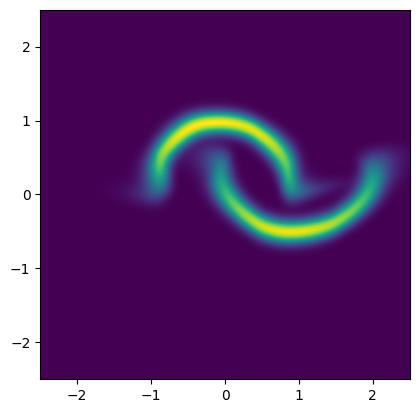

In [15]:
test(maf, n=500, lim=2.5)

# NSF

In [29]:
nsf = NSF(
    inputs=2,
    conditions=1,
    bounds=None,
    hidden=10,
    blocks=2,
    activation=torch.nn.functional.relu,
    dropout=0.,
    norm_within=False,
    transforms=5,
    permutation='reverse',
    linear='lu',
    norm_inputs=None,
    norm_conditions=None,
    norm_between=True,
    embedding=torch.nn.Identity(),
    distribution=None,
    mask='mid',
    bins=10,
    tails='linear',
    bound=5.,
    )

epoch, loss, maf = train(nsf)

0 2.2411537170410156
1 2.2171146869659424
2 2.1539061069488525
3 2.091630697250366
4 2.0166680812835693
5 1.9408527612686157
6 1.9259518384933472
7 1.891849160194397
8 1.7747457027435303
9 1.8370698690414429
10 1.7713719606399536
11 1.7788455486297607
12 1.7483503818511963
13 1.6564488410949707
14 1.686506748199463
15 1.6932168006896973
16 1.6977102756500244
17 1.6693114042282104
18 1.5873262882232666
19 1.6681444644927979
20 1.6299350261688232
21 1.5873572826385498
22 1.5134673118591309
23 1.5441821813583374
24 1.5830433368682861
25 1.509526014328003
26 1.524622917175293
27 1.4661614894866943
28 1.4802978038787842
29 1.446171522140503
30 1.3490082025527954
31 1.410624384880066
32 1.3777375221252441
33 1.3142874240875244
34 1.4515563249588013
35 1.3431222438812256
36 1.3314741849899292
37 1.402786135673523
38 1.3198119401931763
39 1.2613334655761719
40 1.2959916591644287
41 1.2608368396759033
42 1.211521863937378
43 1.2380017042160034
44 1.2476173639297485
45 1.1656005382537842
46 1.17

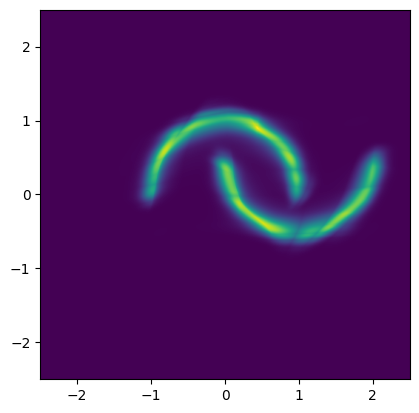

In [30]:
test(maf, n=500, lim=2.5)